<h1><center>Timeseries analysis of blood sugar level. Regression models for predicting blood sugar of patients</center></h1>

## Introduction

This notebook analyses the blood sugar. The blood sugar values were taken using blood sugar sensor for continous monitoring. The measures are in mmol/dL.

<b>Please note, that I am not a physician and the work should not be considered as a repacement of medical consultations or as a way of predicting the blood glucose of real patient.</b>

The results of the work show that the blood sugar behaves like random walk and could not be predicted as accurate as its required for patients needs

## Data Collection


A sensor called Freestyle libre was attached to the arm of a person. A miao miao 2 reader reads the sensor data every 5 minutes and forwards the values to a mobile application called
Spike. IFTTT application was triggered, when Spike receives new values and writes these values to Google spreadsheet

The image shows the data collection architecture
 <div class="container" style="width:50%; height:50%">
  <img src="data_collection_architecture.png" style="width:60%; height:60%">
  <div class="text-block">
    <h4>Image 1. Data collection architecture</h4>
  </div>
</div> 

## Exploratory data analysis and data preparation

The blood glucose changes based on time. The insulin and carbohydrates quantity also affect the blood sugar level.
The subject of the data collection uses Novorapid as rapid/bolus insulin and Lantus as basal insulin.
Below you can view the timed based absorption of bolus and basal insulin. 
A constant is good aproximation of lantus insulin, which has higher acting time. 
The graphic shows that the rapid acting insulin has a peak, where the slow acting has not


In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error 
import datetime
import warnings
from math import sqrt
from sklearn.metrics import r2_score
from pandas import concat, DataFrame
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.model_selection import train_test_split
from joblib import dump, load
from statsmodels.tsa.stattools import adfuller
from sklearn import tree

### Data description

The dataset consist of following columns:

- timestap [datetime], formatted as  %m %d, %y at %H:%M%p. The "at" will prevent us from converting to datetime and should be removed
- Exporting application [categorical] - the name of the application ,which exports the metrics from the sensor to the smartphone
- Blood glucose [numerical] - blood glucose values as time series
- Increase [categorical] -  high extreme,high,low,low extreme
- Slope [numerical] - the difference between the blood glucose in t and in t-1.
- Bolus [numerical] - the rapid acting insulin injected in time t
- Basal [numerical] - the slow acting insulin injected in time t

To clean the dataset following action will be performed:

1. Replace "at" in timestamp column and convert the column to datetime
2. Drop columns ["Exporting application","Increase","Slope"] - this data is already available, using the Blood glucose column or is unnecessary
3. Convert points of basal and bolus insulin to timeseries. The points did not reflect the insulin acting time and peaks.
4. Downsampling will be used to increase the interval from 5 minutes to 30 minutes

To convert the fast acting insulin points to timeseries we will use following function as approximation to the insulin activity in time:


$$ tau=tp\frac{(1-\frac{tp}{td})}{(1-2\frac{tp}{td})} $$
$$ a = 2\frac{tau}{td} $$
$$ S=\frac{1}{1-a+(1+a)\exp^\frac{-t}{tau}} $$
$$ \\ $$
$$ \\ $$

$$ Ia(t)= IU\frac{S}{tau^2}t(1-\frac{t}{td})\exp^\frac{-t}{tau} $$

- td - total activity of the insulin in minutes
- tp - peak time of the insulin
- tau -  time constant of exponential decay
- a - rise factor
- S - auxiliary scale factor
- Ia(t) - insulin activity curve
- IU - Insulin units

To convert the slow actin insulin points to timeseries it is enough to devide the insulin units by the 24 time in minutes



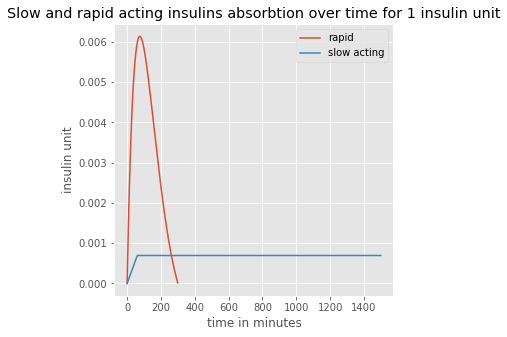

In [2]:
td = 300
tp = 75
tau = tp*(1-tp/td)/(1-2*tp/td)
a = 2*tau/td
S = 1/(1-a+(1+a)*np.exp(-td/tau))
counter = 0
insulin_activity_function = lambda t : (S/np.power(tau,2))*t*(1-t/td)*np.exp(-t/tau)
x = []
y = []
summ = 0
for t in range(0,300,1):
    
    ia = sum(list(map (insulin_activity_function,[t])))
    summ=summ+1
    y.append(ia*1)
    x.append(t)
plt.figure(figsize=(5,5))
plt.xlabel("time in minutes")
plt.ylabel("insulin unit")
plt.plot(x,y)

x_basal = []
y_basal = []
constant = 1/1440 
for t in range(0,1500,1):
    x_basal.append(t)
    if (t<60 and t>=0):
        y_basal.append((t/(60))*constant)
    else:
        y_basal.append(constant)
plt.title("Slow and rapid acting insulins absorbtion over time for 1 insulin unit")

plt.plot(x_basal,y_basal)
plt.legend(["rapid","slow acting"])
plt.show()

The graphics shows the comparison between slow and rapid actin insulin

### Data tidying

In [3]:
blood_glucose_dataset = pd.read_csv("./blood_sugar_insulin_time_series.csv",header=None)

In [4]:
blood_glucose_dataset[0] = blood_glucose_dataset[0]+blood_glucose_dataset[1]
blood_glucose_dataset.drop(columns=[1,2,4,5],axis=1,inplace=True)
blood_glucose_dataset.columns = ["DATETIME","BLOOD_GLUCOSE","BOLUS","BASAL"]

In [5]:
blood_glucose_dataset.dtypes

DATETIME          object
BLOOD_GLUCOSE     object
BOLUS            float64
BASAL            float64
dtype: object

In [6]:
blood_glucose_dataset.shape

(4613, 4)

In [7]:
blood_glucose_dataset.dtypes

DATETIME          object
BLOOD_GLUCOSE     object
BOLUS            float64
BASAL            float64
dtype: object

In [8]:
blood_glucose_dataset["BLOOD_GLUCOSE"] = blood_glucose_dataset["BLOOD_GLUCOSE"].replace(["LOW"], 2.2)
blood_glucose_dataset["BLOOD_GLUCOSE"] = blood_glucose_dataset["BLOOD_GLUCOSE"].replace(["HIGH"], 20)
blood_glucose_dataset["BLOOD_GLUCOSE"] = blood_glucose_dataset.BLOOD_GLUCOSE.astype("float64")


In [9]:
blood_glucose_dataset["DATETIME"] = blood_glucose_dataset["DATETIME"].str.replace('at','')
blood_glucose_dataset["DATETIME"] = pd.to_datetime(blood_glucose_dataset["DATETIME"])

In [10]:
blood_glucose_dataset.dtypes

DATETIME         datetime64[ns]
BLOOD_GLUCOSE           float64
BOLUS                   float64
BASAL                   float64
dtype: object

### Data visualization

Data visualization is used to display the values, trends, seasonality and peaks.

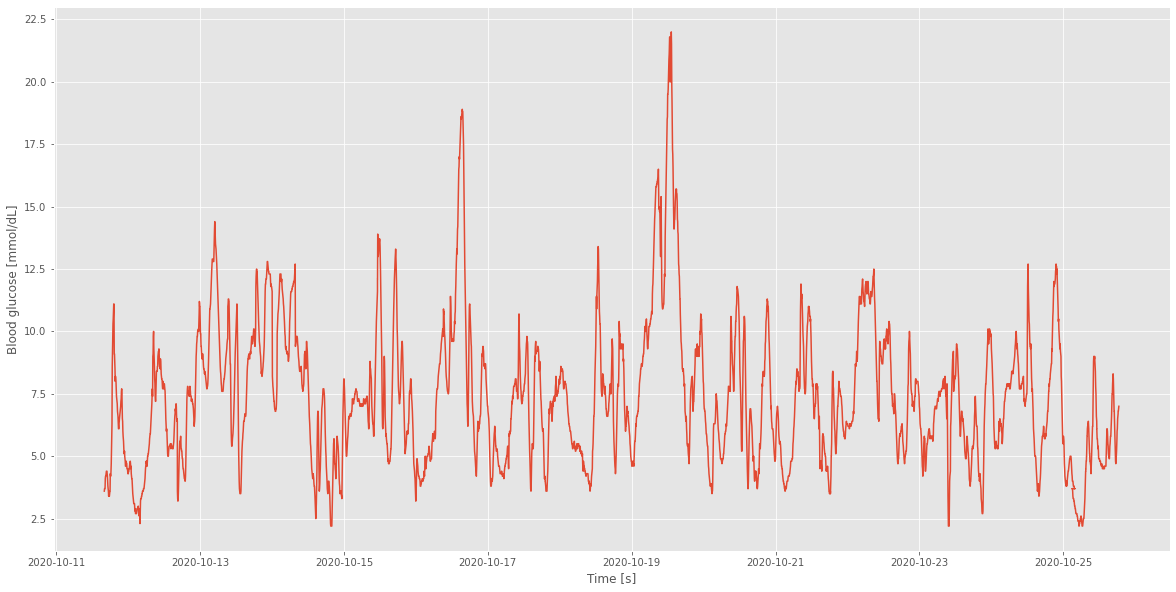

In [11]:
blood_glucose_dataset.head(10)
plt.figure(figsize=(20,10))
plt.plot(blood_glucose_dataset["DATETIME"],blood_glucose_dataset["BLOOD_GLUCOSE"])
plt.xlabel("Time [s]")
plt.ylabel("Blood glucose [mmol/dL]")
plt.show()




In [12]:
blood_glucose_dataset.fillna(0,inplace=True)

In [13]:
blood_glucose_dataset.to_excel('blood_sugar_data.xls')

In [14]:

def get_rapid_insulin_on_board(units,duration,peak):
    """
	Gets the rapid insulin data point to timeseries for 5 minutes interval by summing the insulin per minute 
	Arguments:
		units: The insulin units quantity
		duration: Duration of the insulin in minutes
		peak: Insulin peak activity in minutes after injecting
	Returns:
		list_of_rapid_insulin_activity: list of insulin activity
	"""
    td = duration
    tp = peak
    tau = tp*(1-tp/td)/(1-2*tp/td)
    a = 2*tau/td
    S = 1/(1-a+(1+a)*np.exp(-td/tau))
    counter = 0
    insulin_activity_function = lambda t : (S/np.power(tau,2))*t*(1-t/td)*np.exp(-t/tau)
    x = []
    y = []
    list_of_rapid_insulin_activity = []
    for t in range(0,td,5):
        ia = sum(list(map (insulin_activity_function,[t,t+1,t+2,t+3,t+4])))
        list_of_rapid_insulin_activity.append(ia*units)
    return list_of_rapid_insulin_activity

def get_basal_insulin_on_board(units,duration):
    """
	Gets the slow insulin data point to timeseries for 5 minutes interval by summing the insulin per minute 
	Arguments:
		units: The insulin units quantity
		duration: Duration of the insulin in minutes
	Returns:
		list_of_basal_insulin_activity: list of insulin activity
	"""
    td = duration
    counter = 0
    insulin_activity_function = lambda t : units/duration
    x = []
    y = []
    list_of_basal_insulin_activity = []
    for t in range(0,td,5):
        ia = sum(list(map (insulin_activity_function,[t,t+1,t+2,t+3,t+4])))
        list_of_basal_insulin_activity.append(ia)
    return list_of_basal_insulin_activity

In [15]:
def transform_rapid_insulin_on_board_to_timeseries(dataframe,duration,peak):
     """
	Transforms the rapid insulin data point to timeseries for 5 minutes interval by summing the insulin per minute 
	Arguments:
		dataframe: The insulin series units quantity
		duration: Duration of the insulin in minutes
		peak: Insulin peak activity in minutes after injecting
	Returns:
		timeseries: the insulin activity timeseries
	"""
    N = len(dataframe[dataframe!=0.0])
    M = len(dataframe)
    timeseries = np.array([ [ 0.0 for i in range(M) ] for j in range(N) ])
    counter = 0
    for index in range(M):
        if (dataframe[index]!=0):
            results = get_rapid_insulin_on_board(dataframe[index],duration,peak)
            position = 0
            while (index+position  < M and position < duration/5):
                timeseries[counter][index+position] =  results[position]
                position = position + 1
            counter = counter + 1
    return timeseries.sum(axis=0)

def transform_basal_insulin_on_board_to_timeseries(dataframe,duration):
    """
	Transforms the slow insulin data point to timeseries for 5 minutes interval by summing the insulin per minute 
	Arguments:
		dataframe: The insulin series units quantity
		duration: Duration of the insulin in minutes
		peak: Insulin peak activity in minutes after injecting
	Returns:
		timeseries: the insulin activity timeseries"""
    N = len(dataframe[dataframe!=0.0])
    M = len(dataframe)
    timeseries = np.array([ [ 0.0 for i in range(M) ] for j in range(N) ])
    counter = 0
    for index in range(M):
        if (dataframe[index]!=0):
            results = get_basal_insulin_on_board(dataframe[index],duration)
            position = 0
            while (index+position  < M and position < duration/5):
                timeseries[counter][index+position] =  results[position]
                position = position + 1
            counter = counter + 1
    return timeseries.sum(axis=0)

In [16]:
blood_glucose_dataset["BOLUS_TS"] = transform_rapid_insulin_on_board_to_timeseries(blood_glucose_dataset["BOLUS"],300,75)

In [17]:
last_day_basal_insulin = blood_glucose_dataset["BASAL"][0]
blood_glucose_dataset["BASAL"][0] = 0
blood_glucose_dataset["BASAL_TS"] = transform_basal_insulin_on_board_to_timeseries(blood_glucose_dataset["BASAL"],1440)
blood_glucose_dataset["BASAL_TS"][0:blood_glucose_dataset["BASAL_TS"].ne(0).idxmax()] = (last_day_basal_insulin/1440)*5
blood_glucose_dataset["BASAL_TS"].to_excel("basal.xls")


In [18]:
blood_glucose_dataset.drop(["BASAL","BOLUS"],axis=1,inplace=True)
blood_glucose_dataset.set_index("DATETIME",inplace=True)

### Aggregating the blood glucose per day for 14 days

The purpose of aggregating the values for each day is to understand and research for possible seasonality and trends.
From the graphics we can conclude, that there is no trend or signs of seasonality.

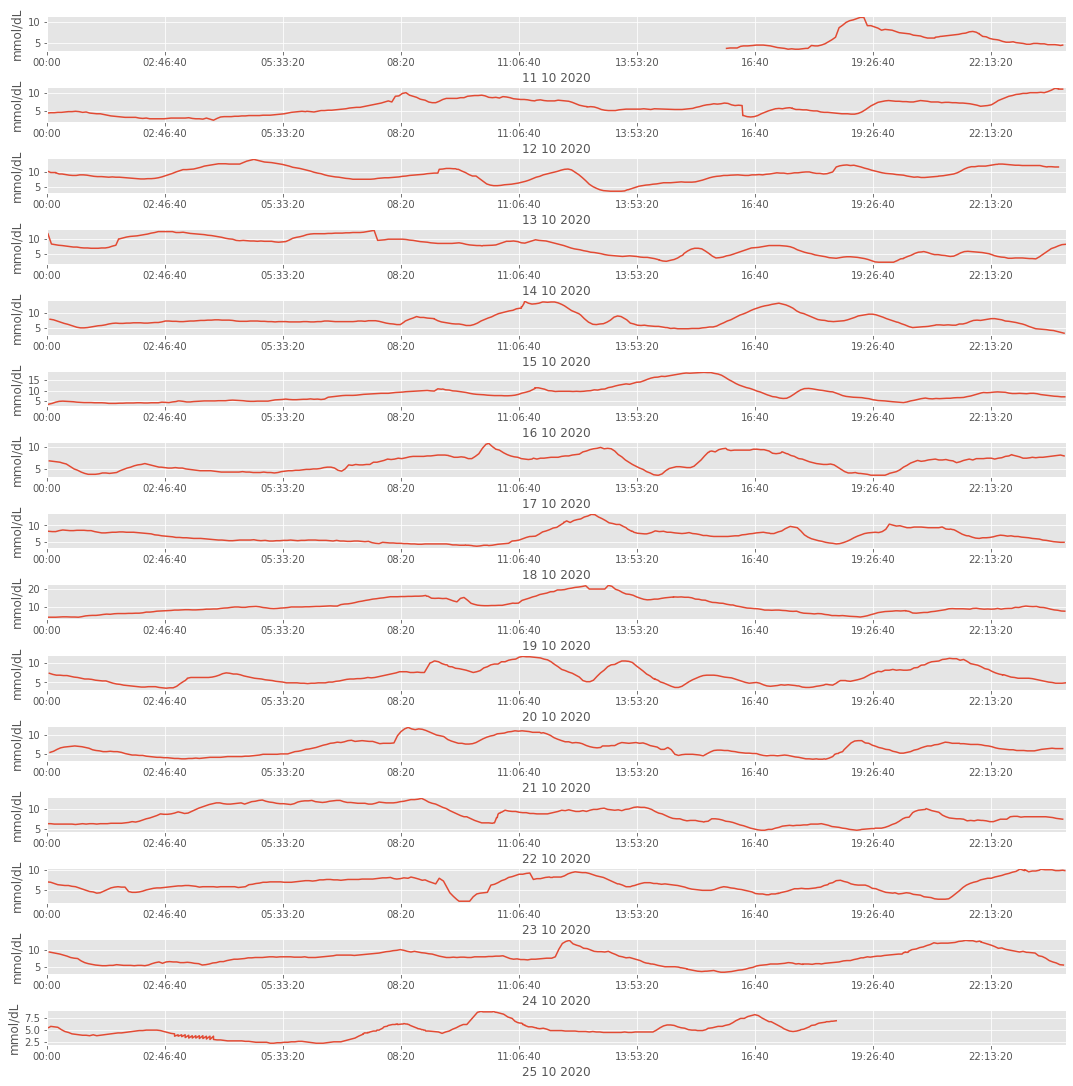

In [19]:
aggregate_one_day = blood_glucose_dataset.groupby(pd.Grouper(freq='1D'))
pd.plotting.register_matplotlib_converters()
fig, ax = plt.subplots(15,figsize=(15,15))
index = 0
fig.tight_layout(pad=1.5)

for group,daily in aggregate_one_day:
    ax[index].plot(daily.index.time,daily['BLOOD_GLUCOSE'])
    ax[index].set_xlim([datetime.time(0,0,0),datetime.time(23,59,59)])
    ax[index].set_xlabel(f"{set(daily.index.day).pop()} {set(daily.index.month ).pop()} {set(daily.index.year).pop()}")
    ax[index].set_ylabel("mmol/dL")
    index = index+1

plt.show()

### Downsampling
The blood glucose was taken every five minutes. Downsampling is used to aggregate the data in 30 minutes interval using average for the blood glucose and sum for the insulin. The purpose is to predict the blood sugar for the next thirty minutes, based on the values before, which is called autoregression

In [20]:

blood_glucose_time_series = blood_glucose_dataset["BLOOD_GLUCOSE"].resample('30min').mean()
basal_time_series = blood_glucose_dataset["BASAL_TS"].resample('30min').sum()
bolus_time_series = blood_glucose_dataset["BOLUS_TS"].resample('30min').sum()

#### Visualizing the downsampled values
A line plot is used to visualize the timeseries after the downsampling process

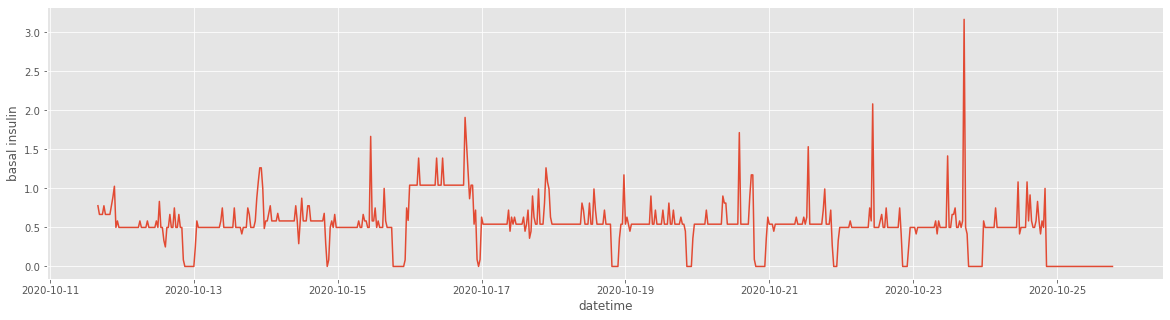

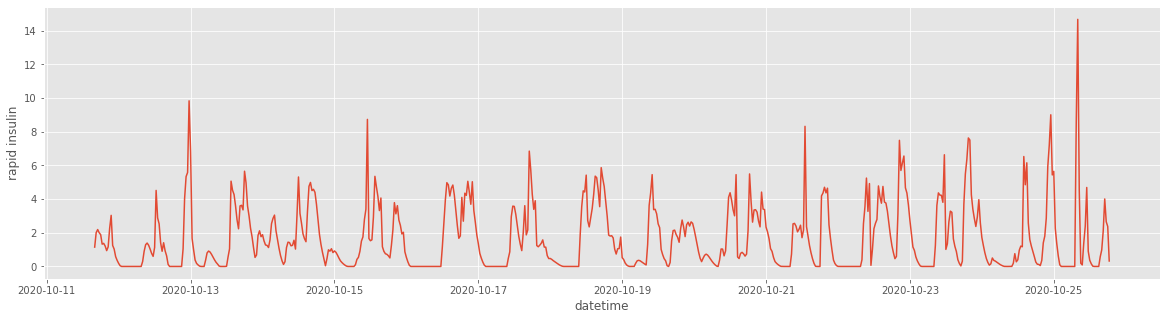

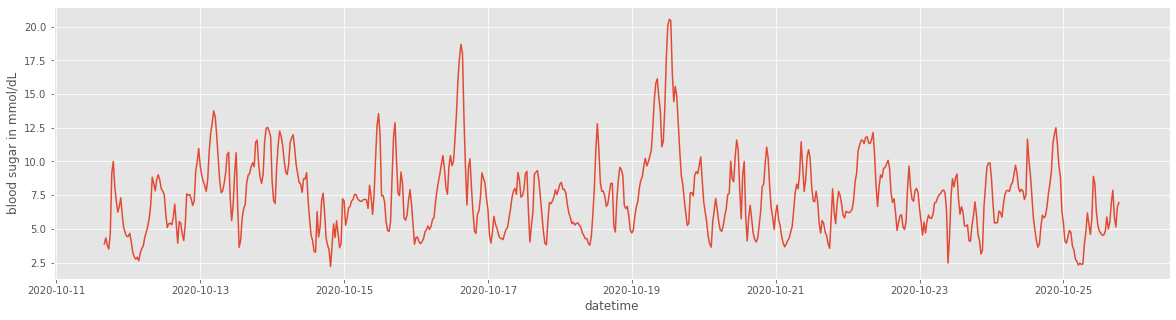

In [21]:
plt.figure(figsize=(20,5))
plt.xlabel("datetime")
plt.ylabel("basal insulin")
plt.plot(basal_time_series)
plt.show()
plt.figure(figsize=(20,5))
plt.xlabel("datetime")
plt.ylabel("rapid insulin")
plt.plot(bolus_time_series)
plt.show()
plt.figure(figsize=(20,5))
plt.xlabel("datetime")
plt.ylabel("blood sugar in mmol/dL")
plt.plot(blood_glucose_time_series)
plt.show()

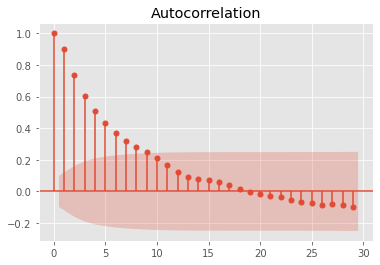

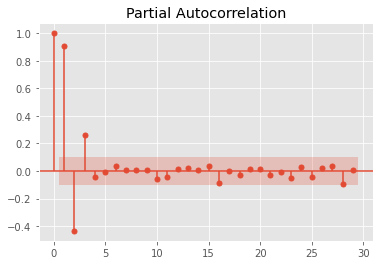

In [22]:

plot_acf(blood_glucose_time_series,alpha=0.01)
plt.show()
plot_pacf(blood_glucose_time_series,alpha=0.01)
plt.show()

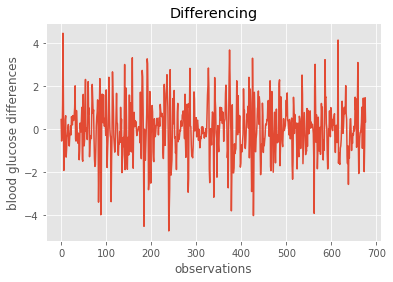

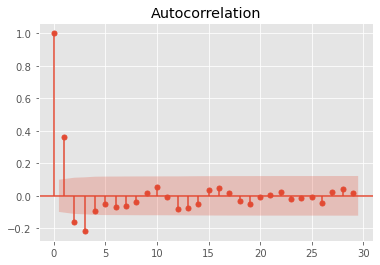

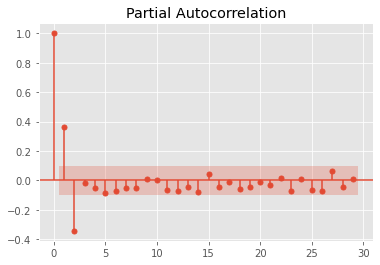

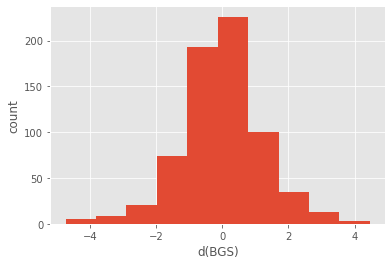

In [23]:
def difference(dataset, interval=1):
    """
	returns the difference using interval, which is the differencing order
	Arguments:
		dataset: features
		interval: differencing order
	Returns:
		numpy array of the differences
	"""
  diff = list()
  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value) 
  return np.array(diff)
diff = difference((blood_glucose_time_series).astype("float32"), ) 
plt.plot(diff)
plt.title("Differencing")
plt.xlabel("observations")
plt.ylabel("blood glucose differences")
plt.show()
plot_acf(diff,alpha=0.01)
plt.show()
plot_pacf(diff,alpha=0.01)
plt.show()
plt.xlabel("d(BGS)")
plt.ylabel("count")
plt.hist(diff)
plt.show()

In [24]:
train_size = int(len(blood_glucose_time_series) * 0.8)
train, test = blood_glucose_time_series[0:train_size], blood_glucose_time_series[train_size:len(blood_glucose_time_series)]

### After differencing the dataset, the autocorrelation changed its behaviour to 4 periods. Two of the periods are positive and two negative. The PACF on the other hand has three periods, two positive and one negative. From the PACF and ACF graphics we can conclude, that the possible values for the period are between 2 and 4

## Training Machine learning models
The blood glucose values and its target are numeric. For numerical problem a regression is used. The selected metrics are R2 and mean squared error. The following models will be trained:

1. ARIMA with gridsearch
2. ARIMA with insulin as exogenous variable
3. Persistance model
4. Converting timeseries to supervised learning problem
5. Regression tree with gridsearch
6. Random forest regression with gridsearch
7. Adaboost with gridsearch
8. Support vector regression with gridsearch
9. XGBoost regression with gridsearch

In order to convert the problem in supervised learning we will shift the data by 5 periods for both blood glucose and insulin and the blood glucose in time t will be used as target. Furthermore before the training the dataset will be devided into training and testing. The testing data will be passed to the gridsearch to receive accurate results.

### Splitting the dataset in training and testing

80 % of the data will be used for training, 20% for testing

### ARIMA gridsearch with p in [0,5), d in [0,3) and q in [0,5)

### ARIMA with insulin as exogenous factor
The insulin has effect on the blood glucose. ARIMA (2,1,3) with exogenour variable could provide better accuracy, although the insulin activity and effects are not linear. 

In [27]:
exogeneous_variables = basal_time_series+bolus_time_series
exog_train, exog_test = exogeneous_variables[0:train_size], exogeneous_variables[train_size:len(exogeneous_variables)]
history = [x for x in train]
predictions = []
for t in range(len(test)):
    model = SARIMAX(history, order=(2,1,3),exog=exog_train)
    model_fit = model.fit()
    output = model_fit.forecast(steps=1,exog=exog_test[t])
    yhat = output
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    exog_train = exog_train.append(pd.Series([exog_test[t]]))
error = mean_squared_error(test,predictions)
print("Test MSE %.3f" % error)
plt.show()
r2_score(test,predictions)

Test MSE 1.038


0.7668585728000121

### Time series should be stationary before model training. To check if blood glucose has no trend or seasonality Augmented Dickey-Fuller test will be performed on the data

- null hypothesis (H0) - the  timeseries can be represented by unit root, which is not stationary, p > 0.05
- alternate hypothesis (H1)- the timeseries is stationary, p<0.05

$$   \Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \delta_1 \Delta y_{t-1} + \cdots + \delta_{p-1} \Delta y_{t-p+1} + \varepsilon_t,  $$


where α   is a constant, β  the coefficient on a time trend and p   the lag order of the autoregressive process. Imposing the constraints α = 0 and β = 0  corresponds to modelling a random walk and using the constraint β = 0 corresponds to modeling a random walk with a drift


In [25]:


result = adfuller(blood_glucose_time_series,) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.607315
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


### Based on the test the timeseries is stationary

In [29]:

insulin_time_series = basal_time_series + bolus_time_series 

R2:  0.7672279249614825


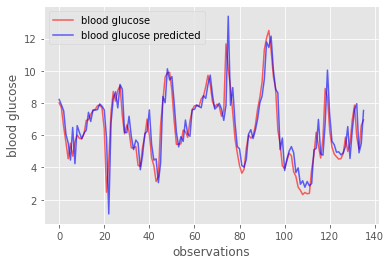

ARIMA(2, 1, 3) RMSE=1.018
Best ARIMA(2, 1, 3) RMSE=1.018


In [26]:
# grid search ARIMA parameters for time series
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order): # prepare training dataset
     """
	Evaluates the model using rmse
	Arguments:
		X: features
		order: ARIMA p,d,q
	Returns:
		rmse
	"""
    X = X.astype('float32')
    train_size = int(len(X) * 0.80)
    train, test = X[0:train_size], X[train_size:] 
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
    # difference data
        model = ARIMA(history, order=arima_order) 
        model_fit = model.fit(trend='nc') 
        yhat = model_fit.forecast()[0]
        predictions.append(yhat[0])
        history.append(test[t])
        # calculate out of sample error
        
        
    rmse = sqrt(mean_squared_error(test, predictions))
    r_squared = r2_score(test,predictions) 
    print("R2: ",r_squared)

    array = []
    for i in test:
        array.append(i)
    
    plt.plot(array,color="r",alpha=0.6)
    plt.plot(predictions,color="b",alpha=0.6)
    plt.xlabel("observations")
    plt.ylabel("blood glucose")
    plt.legend(['blood glucose', 'blood glucose predicted']);
    plt.show()
    return rmse 

def evaluate_models(dataset, p_values, d_values, q_values): 
      """
	Evaluates the models using rmse and prints the best according to the lowest RMSE
	Arguments:
		dataset: features
		p: period
        d: differencing
        q: regression of the residuals
	Returns:
		none
	"""
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    
    for p in p_values:
        for d in d_values: 
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order) 
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order 
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))     


p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
# blood_glucose_dataset["BLOOD GLUCOSE"]
evaluate_models(blood_glucose_time_series, p_values, d_values,q_values)

### The ARIMA with lowest root mean squared error of 1.018 is (2,1,3)

In [30]:
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [31]:
 
blood_glucose_values = [x for x in blood_glucose_time_series]
blood_glucose_supervised_dataset = series_to_supervised(blood_glucose_values,5)
blood_glucose_supervised_dataset.columns = ["blood(t-5)","blood(t-4)","blood(t-3)","blood(t-2)","blood(t-1)","blood(t)"]
blood_glucose_supervised_dataset.dtypes

blood(t-5)    float64
blood(t-4)    float64
blood(t-3)    float64
blood(t-2)    float64
blood(t-1)    float64
blood(t)      float64
dtype: object

### All ARIMA models have very close mean squared error. ARIMAX does not improve the performance, although we increase the complexity of the model.The timeseries is stationary. It looks, that the dataset is random walk and could not be predicted. A Persistance model is used to check if the best prediction of value(t) is the value(t-1). The machine learning model should provide better results than the persistance model if the value could be predicted. 

### Persistance model

In [28]:
history = train[-1]
predictions = list()
for i in range(len(test)):
	yhat = history
	predictions.append(yhat)
	history = test[i]
error = mean_squared_error(test, predictions)
print('Persistence MSE: %.3f' % error)

Persistence MSE: 1.256


### Converting the timeseries to supervised learning problem
1. To convert the problem to supervised learning a shift will be performed on the dataset by 5 periods
2. A sum will performed on the rapid and slow acting insulin to convert the column into one feature

In [32]:
insulin_glucose_values = [x for x in insulin_time_series]
insulin_glucose_supervised_dataset = series_to_supervised(insulin_glucose_values,5)
insulin_glucose_supervised_dataset.columns = ["insulin(t-5)","insulin(t-4)","insulin(t-3)","insulin(t-2)","insulin(t-1)","insulin(t)"]
insulin_glucose_supervised_dataset=insulin_glucose_supervised_dataset.astype("float64")

In [33]:
combined_insulin_blood_glucose = pd.concat([blood_glucose_supervised_dataset,insulin_glucose_supervised_dataset],axis=1,join="inner")
combined_insulin_blood_glucose

,blood(t-5),blood(t-4),blood(t-3),blood(t-2),blood(t-1),blood(t),insulin(t-5),insulin(t-4),insulin(t-3),insulin(t-2),insulin(t-1),insulin(t)
5,3.885714,4.333333,3.783333,3.500000,4.671429,9.133333,1.925868,2.675936,2.858259,2.671102,2.665781,1.990493
6,4.333333,3.783333,3.500000,4.671429,9.133333,10.000000,2.675936,2.858259,2.671102,2.665781,1.990493,2.038789
7,3.783333,3.500000,4.671429,9.133333,10.000000,8.083333,2.858259,2.671102,2.665781,1.990493,2.038789,1.878003
8,3.500000,4.671429,9.133333,10.000000,8.083333,7.083333,2.671102,2.665781,1.990493,2.038789,1.878003,1.607140
9,4.671429,9.133333,10.000000,8.083333,7.083333,6.242857,2.665781,1.990493,2.038789,1.878003,1.607140,1.939465
...,...,...,...,...,...,...,...,...,...,...,...,...
673,4.860000,5.883333,4.992308,5.516667,6.960000,7.866667,0.000000,0.000000,0.000000,0.574045,0.982614,2.113475
674,5.883333,4.992308,5.516667,6.960000,7.866667,5.890000,0.000000,0.000000,0.574045,0.982614,2.113475,4.009943
675,4.992308,5.516667,6.960000,7.866667,5.890000,5.137500,0.000000,0.574045,0.982614,2.113475,4.009943,2.655906
676,5.516667,6.960000,7.866667,5.890000,5.137500,6.600000,0.574045,0.982614,2.113475,4.009943,2.655906,2.375621


### Check of the shifted blood glucose values

### Check of the shifted insulin values and concatenation

<AxesSubplot:>

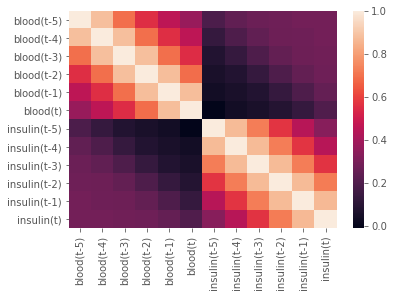

In [34]:
corr = combined_insulin_blood_glucose.corr(method='spearman')
sns.heatmap(corr)

R2:  0.804883118650093
MSE:  1.6682514747891206


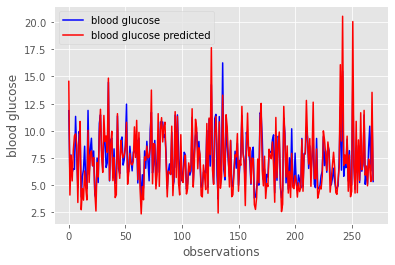

In [35]:
y = combined_insulin_blood_glucose["blood(t)"]
X = combined_insulin_blood_glucose.drop(["blood(t)"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
hyperparameters = {
 'randomforestregressor__max_depth': [1,5,10,'None'],
 'randomforestregressor__max_features': [1,2,3,4,5,6,7,8,9,10,11],
 'randomforestregressor__max_samples': [10,20,30,40,50,60,70,80,90,100],
 'randomforestregressor__n_estimators': [10,50,100,1000]}
pipeline = make_pipeline(StandardScaler(), 
                         RandomForestRegressor())
clf = GridSearchCV(pipeline, hyperparameters, cv=3)
clf.fit(X_train, y_train)
clf.best_params_
dump(clf, 'randomforest.joblib') 
y_pred = clf.predict(X_test)

y_test=y_test.to_numpy()
print("R2: ",r2_score(y_test, y_pred))
print("MSE: ",mean_squared_error(y_test, y_pred))
plt.plot(y_pred,c="b")
plt.plot(y_test,c="r")
plt.xlabel("observations")
plt.ylabel("blood glucose")
plt.legend(['blood glucose', 'blood glucose predicted'])
plt.show()


### Spearman correlation of insulin and blood glucose
In contrast to Pearson the Spearman correlation will perform well even if the elationship is not linear

### Random forest regression

Before we model the dataset will be scaled with StandardScaler, which transforms the dataset to have a mean of 0 and standarddeviation of 1 

$$ z= \frac{x-\mu}{\sigma} $$

Random forest has following hyperparameters:
- max_depth - the maximum depth or level of the tree
- max_feature - the number of features that is randomly sampled for each split point
- max_samples - the percentage of the training data, used for the bootstrap sample to train each tree.
- n_estimators - the number of trees
 

{'adaboostregressor__learning_rate': 0.001, 'adaboostregressor__n_estimators': 1000}
R2:  0.7985224245405003
MSE:  1.72263547916433


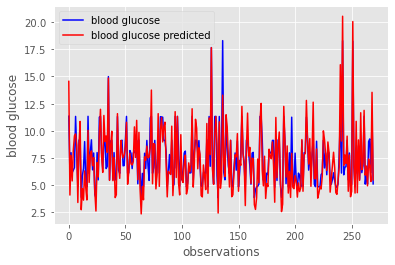

In [37]:
param_dist = {
 'adaboostregressor__n_estimators': [10,50,100,1000],
 'adaboostregressor__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1.0]
 }

pipeline_adaboost = make_pipeline(StandardScaler(), 
                         AdaBoostRegressor(random_state=0))
clf_adaboost = GridSearchCV(pipeline_adaboost, param_dist, cv=3)

clf_adaboost.fit(X_train, y_train)
print(clf_adaboost.best_params_)
y_pred_adaboost = clf_adaboost.predict(X_test)

print("R2: ",r2_score(y_test, y_pred_adaboost))
print("MSE: ",mean_squared_error(y_test, y_pred_adaboost))
plt.plot(y_pred_adaboost,c="b")
plt.plot(y_test,c="r")
plt.xlabel("observations")
plt.ylabel("blood glucose")
plt.legend(['blood glucose', 'blood glucose predicted'])
plt.show()

{'decisiontreeregressor__criterion': 'mse', 'decisiontreeregressor__max_depth': 5, 'decisiontreeregressor__max_leaf_nodes': 8, 'decisiontreeregressor__min_samples_leaf': 5, 'decisiontreeregressor__min_samples_split': 2}
0.7888181568684867
1.8173295201741613


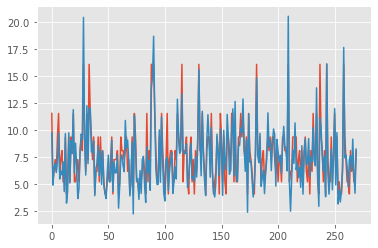

In [50]:
param_dist_tree = {
              "decisiontreeregressor__max_depth": [1,5,10,'None'],
              "decisiontreeregressor__max_features": [1,2,3,4,5,6,7,8,9,10,11],
              "decisiontreeregressor__min_samples_leaf": [1,2,3,4,5,6,7,8,10]
              }



pipeline_tree = make_pipeline(StandardScaler(), 
                         DecisionTreeRegressor())
clf_tree= GridSearchCV(pipeline_tree, param_dist_tree, cv=3)

clf_tree.fit(X_train, y_train)
print(clf_tree.best_params_)
y_pred_dt = clf_tree.predict(X_test)
dump(clf_tree, 'tree.joblib') 
print("R2: ", r2_score(y_test, y_pred_dt))
print("MSE: ", mean_squared_error(y_test, y_pred_dt))
plt.plot(y_pred_dt,c="b")
plt.plot(y_test,c="r")
plt.xlabel("observations")
plt.ylabel("blood glucose")
plt.legend(['blood glucose', 'blood glucose predicted'])
plt.show()

In [38]:

params = {
    "svr__C": [1e0, 1e1, 1e2, 1e3,1e4,1e6],
    'svr__kernel':['linear','poly', 'rbf', 'sigmoid']
}
pipeline_svr = make_pipeline(StandardScaler(),
                         SVR())
clf_svr= GridSearchCV(pipeline_svr, params, cv=3)

clf_svr.fit(X_train, y_train)
print(clf_svr.best_params_)
y_pred_svr = clf_svr.predict(X_test)
dump(clf_svr, 'svr.joblib')
print("R2: ",r2_score(y_test, y_pred_svr))
print("MSE: ",mean_squared_error(y_test, y_pred_svr))
plt.plot(y_pred_svr,c="b")
plt.plot(y_test,c="r")
plt.xlabel("observations")
plt.ylabel("blood glucose")
plt.legend(['blood glucose', 'blood glucose predicted'])
plt.show()

### Adaptive boosting regression

Before we model the dataset will be scaled with StandardScaler, which transforms the dataset to have a mean of 0 and standarddeviation of 1 

$$ z= \frac{x-\mu}{\sigma} $$

AdaBoost has following hyperparameters:
- n_estimators - the number of trees
- learning_rate - if the value is too big, the minimum could be missed. If the value is too small, then the training will take bigger time. A logarithmic scale is used for the learning rate.
- max_depth - the maximum depth or level of the tree


In [ ]:
from xgboost import XGBRegressor

xgb_params_grid = {"xgbregressor__learning_rate"    : [0.0001, 0.001, 0.01, 0.1, 1.0] ,
 "xgbregressor__max_depth"        : [1,5,10,'None'],
 "xgbregressor__min_child_weight" : [0,1,5,10,20,50],
 "xgbregressor__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "xgbregressor__subsample" : [ 0.5 , 0.7 ,0.9,1.0] }
xgb_pipeline = make_pipeline(StandardScaler(),XGBRegressor())



clf_xgb = GridSearchCV(xgb_pipeline,xgb_params_grid, cv=3)

clf_xgb.fit(X_train, y_train)
print(clf_xgb.best_params_)
y_pred_xgb = clf_xgb.predict(X_test)
dump(clf_xgb, 'xgb.joblib')
print("R2: ",r2_score(y_test, y_pred_xgb))
print("MSE: ",mean_squared_error(y_test, y_pred_xgb))
plt.plot(y_pred_xgb,c="b")
plt.plot(y_test,c="r")
plt.xlabel("observations")
plt.ylabel("blood glucose")
plt.legend(['blood glucose', 'blood glucose predicted'])
plt.show()


### Desicion tree regression

Before we model the dataset will be scaled with StandardScaler, which transforms the dataset to have a mean of 0 and standarddeviation of 1 

$$ z= \frac{x-\mu}{\sigma} $$

Desicion tree has following hyperparameters:
- n_estimators - the number of trees
- learning_rate - if the value is too big, the minimum could be missed. If the value is too small, then the training will take bigger time. A logarithmic scale is used for the learning rate.
- max_depth - the maximum depth or level of the tree
- min_samples_leaf - The minimum number of samples required to be at a leaf node



### Support Vector Regression

Before we model the dataset will be scaled with StandardScaler, which transforms the dataset to have a mean of 0 and standarddeviation of 1 

$$ z= \frac{x-\mu}{\sigma} $$

Support vector regression uses supporting vectors to devide the values

$$     minimize  {\frac {1}{2}}\|w\|^{2} $$
    subject to $$ {\displaystyle |y_{i}-\langle w,x_{i}\rangle -b|\leq \varepsilon } $$

- x - training sample
- y - target
- w - orthonormal vector

SVR has following hyperparameters:
- C - penalty or regularization in logarithmic scale
- kernel - Specifies the kernel type to be used in the algorithm


### Visualizing the desicion tree
One of the key benefits of using desicion tree is the possibility to plot the tree

In [ ]:
tree.plot_tree(clf_tree.best_estmiator_)

### XGBoost

Before we model the dataset will be scaled with StandardScaler, which transforms the dataset to have a mean of 0 and standarddeviation of 1 


XGBoost has following hyperparameters:
- max_depth - the maximum depth or level of the tree
- min_child_weight - minimum sum of instance weight (hessian) needed in a child. Larget values will make the model more conservative.
- learning_rate - if the value is too big, the minimum could be missed. If the value is too small, then the training will take bigger time. A logarithmic scale is used for the learning rate.
- gamma - regularization
- subsample - subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.

## Conclusions
Some of regression models have slightly better result than the persistance model like SVR. The trees on the other hand have worse performance based on R2 and MSE. Based on the results, we can conclude that the blood glucose is random walk and could not be predicted accurately.

To improve the results a combination of the algorithms could be used by averaging the outputs of the models and calculating the score between the average predicted value and the observed value

## Code improvements
- The pipelines are called multiple times and could be defined as one function with hyperparameters and model as method parameters.
- All function should have docstring in order to be reused in future works
- Pickle or joblib could be used to save the models and retrieve the back.